# Imports

In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload
import os
from os.path import join
import random
import pathlib
import re
from collections import defaultdict
import shutil

import nibabel as nib
import cv2
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.morphology as morp
import skimage.measure as meas
from scipy.ndimage import rotate
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import pyqtgraph
import networkx as nx
import open3d as o3d
from open3d.web_visualizer import draw

import general.open3d_utils as ou
import general.queue as qu
import general.utils as u
import general.array_morphology as am
import ssm.best_fit_transform as bft
import ssm.utils as su
import ssm.icp as icp
import ssm.hungarian_icp as hicp
import ssm.dijkstra as dij
import ssm.sample_mesh as smesh
import ssm.shape as sh
import ssm.read_iliac as ri

def reload_modules():
    for modl in [bft, ou, qu, u, am, su, icp, hicp, dij, smesh, sh, ri]:
        reload(modl)

reload_modules()
print('Done.')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.
Done.


In [4]:
%matplotlib notebook

In [38]:
def get_normal_lineset(pcd, normals):
    pcdn = ou.numpy_to_o3d_pcd(np.asarray(pcd.points) + normals, normals=normals)
    line_set = o3d.geometry.LineSet()
    line_set.points = (pcd + pcdn).points
    line_set.lines = o3d.utility.Vector2iVector([[i, i + len(normals)] for i in range(len(normals))])
    return line_set

def get_lineset_matches(pcd1, pcd2):
    n_points = len(np.asarray(pcd1.points))
    line_set = o3d.geometry.LineSet()
    line_set.points = (pcd1 + pcd2).points
    line_set.lines = o3d.utility.Vector2iVector(
        [[i, n_points + i] for i in range(n_points)]
    )
    return line_set

In [121]:
MESH_DIR = "/hdd/datasets/CT-ORG/meshes/labels/"
STEP_SIZE = 4


blacklist = [
    '/hdd/datasets/CT-ORG/meshes/labels/labels-20/step_size_4',
    '/hdd/datasets/CT-ORG/meshes/labels/labels-19/step_size_4',
]

all_meshes = su.sort_by_regex(list(set([
    os.path.join(MESH_DIR, filename, f"step_size_{STEP_SIZE}") for filename in os.listdir(MESH_DIR)
]).difference(blacklist)))



# Test Open3d

In [ ]:
cube_red = o3d.geometry.TriangleMesh.create_box(1, 2, 4)
cube_red.compute_vertex_normals()
cube_red.paint_uniform_color((1.0, 0.0, 0.0))
draw(cube_red)

In [22]:
%%time
path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=2)
print(len(verts1), len(faces1))

11328 22652
CPU times: user 11.8 s, sys: 7.74 s, total: 19.5 s
Wall time: 9.87 s


In [ ]:
pcd = numpy_to_o3d_pcd(verts1)
draw(pcd)

In [ ]:
msh = numpy_to_o3d_mesh(verts1, faces1, normals1)
draw([msh])

# Sampling

### 2D Tests

In [5]:
def check_same_dict(dic1, dic2):
    assert len(dic1) == len(dic2)
    same = True
    for key in dic1:
        same = same and dic1[key] == dic2[key]
    return same

In [6]:
reload_modules()
def create_grid_graph(W, H):
    graph = dij.Graph()

    for i in range(1, W - 1):
        for j in range(1, H - 1):
            if (i, j) in graph.nodes:
                continue
            graph.add_node((i, j))
            for (k1, k2) in [(-1, 0), (1, 0), (0, 1), (0, -1),]:
                graph.add_node((i + k1, j + k2))
                value = 1
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
            for (k1, k2) in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                graph.add_node((i + k1, j + k2))
                value = np.sqrt(2)
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
                             
    return graph

In [ ]:
%%time
reload_modules()

n = 100
graph = create_grid_graph(n, n)

t1 = time()
visited, path, closest = dij.dijkstra(graph, [(n//2, n//2)])
print("Dijkstra Time:", time() - t1)

points = []
ar = np.zeros((n, n))
for (i, j) in visited:
    ar[i, j] = visited[(i, j)]

fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(ar)

ax = fig.add_subplot(122)
ax.imshow(np.cos(.5 * ar))

### On Data

In [6]:
%%time
# path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
# seg1n = nib.load(path_segm)
# seg1 = np.round(seg1n.get_fdata()) == 2
# reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
# verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=2)
# print(len(verts1), len(faces1))
path_shape = '/hdd/datasets/CT-ORG/meshes/labels/labels-11/step_size_2'
cur_shape = sh.Shape.load_from_path(path_shape)
print(len(cur_shape.vertexes), len(cur_shape.faces))

11328 22652
CPU times: user 4.15 ms, sys: 4.34 ms, total: 8.49 ms
Wall time: 3.71 ms


In [ ]:
reload_modules()
cur_msh = cur_shape.o3d_mesh()
draw(cur_msh)

In [ ]:
# Parcours en largeur

# Q = Queue()
# fronts = []

# node = 0
# already_visited = set()

# gmesh = sm.create_mesh_graph(shape_to_plots[0].vertexes, shape_to_plots[0].faces)
# closest = shape_to_plots[0].closest_sample_point

# for child in gmesh.edges[node]:
#     already_visited.add(child)
#     Q.add((child, node))

# i = 0
# while not Q.is_empty():
#     node, parent = Q.pop()
#     for child in gmesh.edges[node].difference(already_visited):
#         already_visited.add(child)
#         Q.add((child, node))
#     if closest[node] != closest[parent]:
#         fronts.append(node)

#     i += 1

#     if i > len(gmesh.nodes):
#         print('Too many nodes !! breaking.')
#         break


In [10]:
reload_modules()
gmesh = smesh.create_mesh_graph(cur_shape.vertexes, cur_shape.faces)
# dists, path, closest = dij.dijkstra(gmesh, initial_set=[0])
all_points, ar_dist, ar_clos = smesh.dijkstra_sampling(gmesh=gmesh, n_points=100, )

100%|██████████| 100/100 [00:00<00:00, 138.67it/s]


In [11]:
# Voronoi cells of a subset of the graph

visited_edges = set()

neighbors = defaultdict(set)
gnei = nx.Graph()

i = 0
for node1 in gmesh.nodes:
    i += 1
    for node2 in gmesh.edges[node1]:
        if (node2, node1) in visited_edges:
            continue
        visited_edges.add((node1, node2))
#         visited_edges.add((node2, node1))
#         c1 = closest[node1]
#         c2 = closest[node2]
        c1, c2 = ar_clos[node1], ar_clos[node2]
        if c1 != c2:
            neighbors[c1].add(c2)
            neighbors[c2].add(c1)
            gnei.add_edge(c1, c2)
    
print(len(visited_edges), i)

33978 11328


<IPython.core.display.Javascript object>


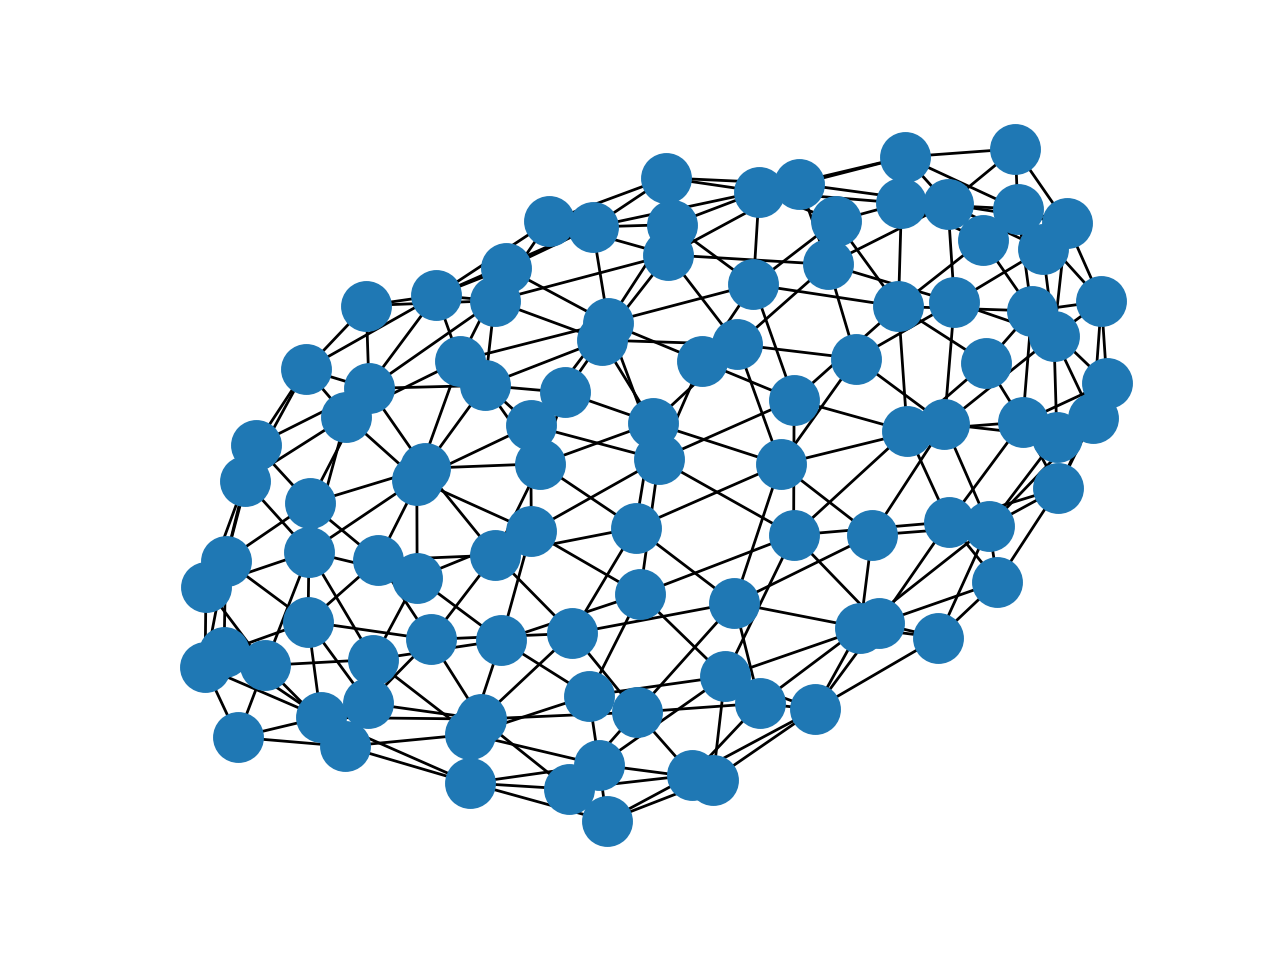

In [12]:
plt.subplot(111)
nx.draw(gnei, with_labels=False)

<IPython.core.display.Javascript object>


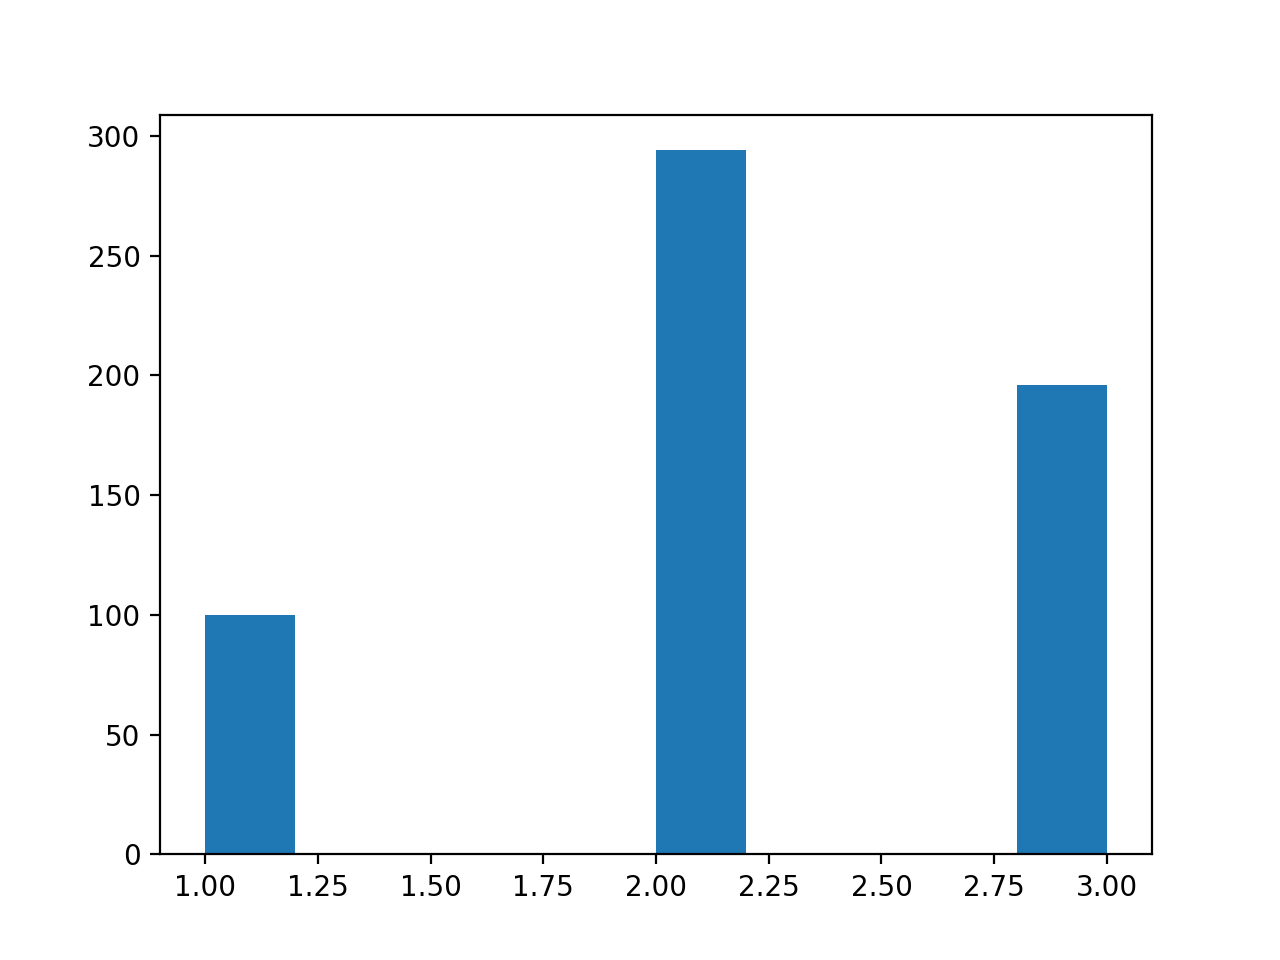

(array([100.,   0.,   0.,   0.,   0., 294.,   0.,   0.,   0., 196.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

In [28]:
len_cliques = [len(clique) for clique in nx.enumerate_all_cliques(gnei)]
plt.hist(len_cliques)

In [ ]:
reload_modules()
faces_sample = np.array(
    [clique for clique in nx.enumerate_all_cliques(gnei) if len(clique) == 3]
)

ou.plot_mesh(cur_shape.vertexes, faces_sample)

In [7]:
all_points, ar_dist, ar_clos = smesh.dijkstra_sampling(verts1, faces1, n_points=100, )

100%|██████████| 100/100 [00:00<00:00, 133.80it/s]


<IPython.core.display.Javascript object>


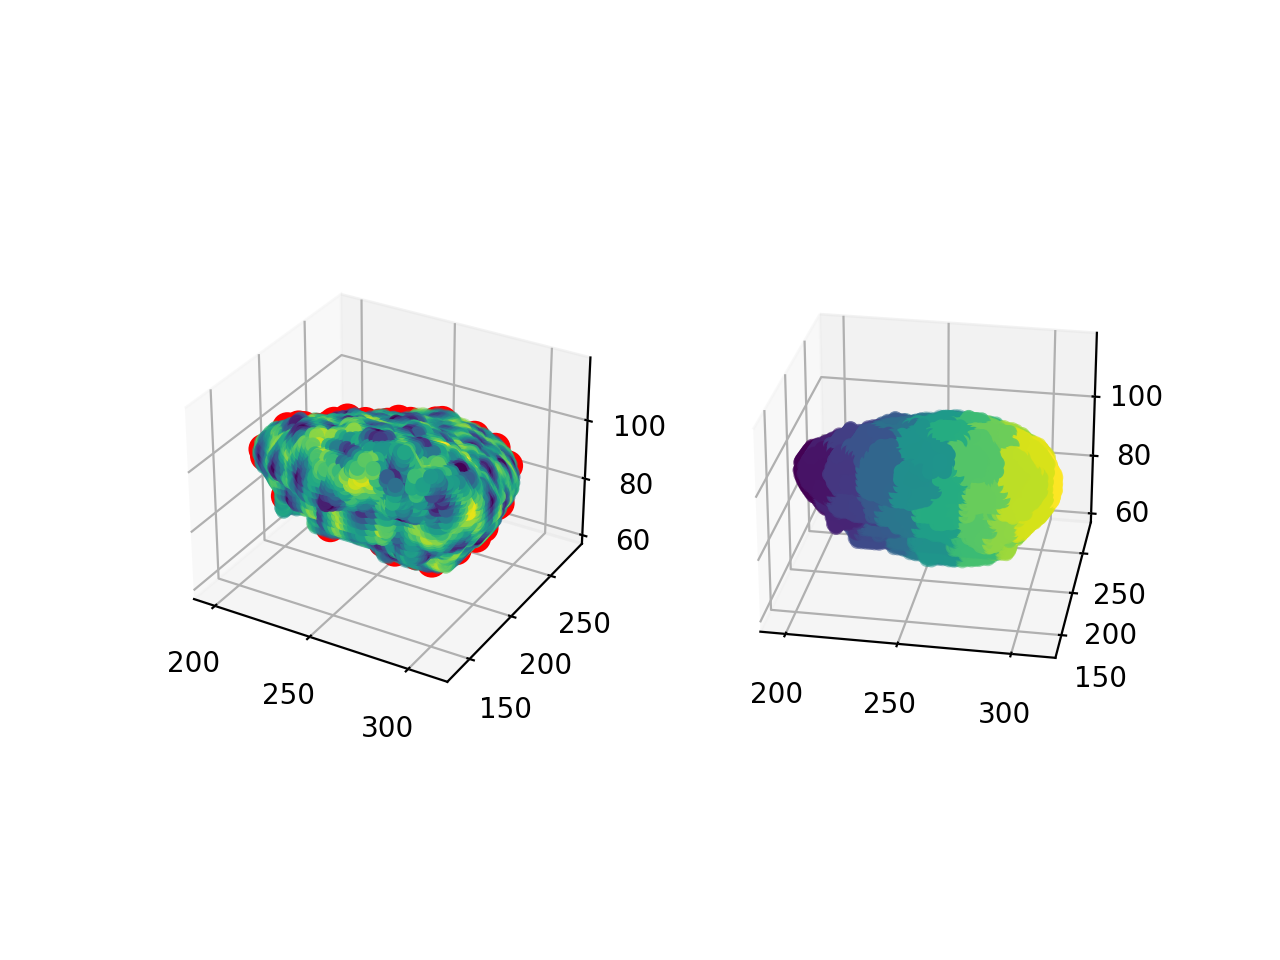

In [8]:
# %%
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

ax.scatter(*verts1.T, c=ar_dist)
ax.scatter(*verts1[all_points].T, c='r', s=100, alpha=1)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*verts1.T, c=ar_clos)



In [ ]:
cur_shape.perform_sampling(n_points=1000, verbose=True)
cur_shape.compute_sample_faces()

mesh_sample = ou.numpy_to_o3d_mesh(vertices=cur_shape.sample, triangles=cur_shape.faces_sample)
mesh_sample.compute_vertex_normals()

cur_mesh = cur_shape.o3d_mesh()
cur_sample = ou.get_o3d_pcd_colored(cur_shape.sample)

draw([
    mesh_sample,
    cur_mesh,
    cur_sample
])

# Method Development

## Test ICP registration

In [35]:
# %%

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-10.nii.gz")
seg2n = nib.load(path_segm)
seg2 = np.round(seg2n.get_fdata()) == 2


In [36]:
%%time
reload_modules()
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
reg2 = (u.get_most_important_regions(seg2) > 0).astype(int)



CPU times: user 16.9 s, sys: 674 ms, total: 17.6 s
Wall time: 17.6 s


In [37]:
%%time
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=4)
verts2, faces2, normals2, values2 = meas.marching_cubes(reg2, step_size=4)


CPU times: user 405 ms, sys: 108 ms, total: 513 ms
Wall time: 512 ms


In [ ]:
# %%
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)
ax.plot_trisurf(*verts2.T, triangles=faces2)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*verts1.T,)
ax.scatter(*verts2.T,)

In [39]:
mean1, std1 = verts1.mean(0), verts1.std(0)
mean2, std2 = verts2.mean(0), verts2.std(0)

nverts1 = (verts1 - mean1)/std1
nverts2 = (verts2 - mean2)/std2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*nverts1.T,)
ax.scatter(*nverts2.T,)

In [41]:
%%time
reload_modules()
T, errs, n_iters = icp.icp(nverts1, nverts2, allow_reflection=False, max_iterations=1000, tolerance=1e-5)
print(T, np.max(errs), n_iters)

[[ 0.99950916  0.02791258  0.01422405  0.01002564]
 [-0.02296148  0.96159541 -0.27350874 -0.13305637]
 [-0.02131212  0.27304788  0.96176434 -0.0616374 ]
 [ 0.          0.          0.          1.        ]] 0.925477981364535 60
CPU times: user 348 ms, sys: 7.21 ms, total: 355 ms
Wall time: 353 ms


In [ ]:
Tverts1 = su.transform_cloud(T, nverts1)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*Tverts1.T,)
ax1.scatter(*nverts2.T,)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(*Tverts1.T, triangles=faces1)
ax2.plot_trisurf(*nverts2.T, triangles=faces2)

In [111]:
Tn1 = su.get_norm_transform(mean1, std1, invert=False)
Tn2 = su.get_norm_transform(mean2, std2, invert=True)
T2 = Tn2 @ T @ Tn1

In [ ]:


# T2verts1 = transform_cloud(T2, verts1 - mean1)
T2verts1 = su.transform_cloud(T2, verts1)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*T2verts1.T, label="T1")
ax1.scatter(*verts2.T, label="2")
ax1.legend()

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*Tverts1.T, label="T1")
ax1.scatter(*nverts2.T, label="2")
ax1.legend()

## Registration with curvature 

In [84]:
""" Curvature computation: 
https://computergraphics.stackexchange.com/questions/1718/what-is-the-simplest-way-to-compute-principal-curvature-for-a-mesh-triangle
"""

def compute_edge_curve(point1, point2, norm1, norm2):
    return (point2 - point1) @ (norm2 - norm1) / np.linalg.norm(point2 - point1)

def compute_all_edge_curve(verts, faces, normals):
    edge_curv = np.zeros((len(verts), len(verts)))
    for face in faces:
        for node1, node2 in [(face[0], face[1]), (face[0], face[2]), (face[1], face[2])]:
            curv = compute_edge_curve(
                verts[node1], verts[node2], normals[node1], normals[node2])
            edge_curv[node1, node2] = curv
            edge_curv[node2, node1] = curv

    return edge_curv

def compute_node_curve(verts, faces, normals):
    edge_curvs = compute_all_edge_curve(verts, faces, normals)
    return edge_curvs.mean(1)

In [161]:
def compute_discrete_laplacian(verts, faces):
    gmesh = smesh.create_mesh_graph(verts, faces)
    laplacian = np.zeros_like(verts)
    for node in gmesh.nodes:
        laplacian[node] = (verts[list(gmesh.edges[node])] - verts[node]).mean(0)
    return laplacian

def compute_node_curve_lap(verts, faces):
    lap = compute_discrete_laplacian(verts, faces)
    return 1/2 * np.sqrt((lap**2).sum(1))

In [131]:
shp1.vertices[[0, 1, 2]] - shp1.vertices[0]

array([[ 0.,  0.,  0.],
       [ 2.,  0., -2.],
       [ 2., -2.,  0.]], dtype=float32)

In [111]:
label_df = pd.read_csv("/hdd/datasets/CT-ORG/meshes/labels_description.csv")

In [ ]:
n_samples = 1000
STEP_SIZE = 4
ORGAN = "bladder"

candidates = label_df[
    (label_df['n_vertexes'] > n_samples) & (label_df['step_size'] == STEP_SIZE) & (label_df['organ'] == ORGAN)
]

shp1 = sh.Shape.load_from_path(candidates['full_path'].iloc[7])
shp2 = sh.Shape.load_from_path(candidates['full_path'].iloc[5])

msh1 = shp1.o3d_mesh()
msh2 = shp2.o3d_mesh()

draw([msh1, msh2])

In [165]:
verts1, faces1, normals1 = shp1.vertexes, shp1.faces, shp1.normals
verts2, faces2, normals2 = shp2.vertexes, shp2.faces, shp2.normals


In [166]:
%%time

# edge_curvs1 = compute_all_edge_curve(verts1, faces1, normals1)
# edge_curvs2 = compute_all_edge_curve(verts2, faces2, normals2)

# node_curvs1 = np.abs(edge_curvs1).mean(1)
# node_curvs2 = np.abs(edge_curvs2).mean(1)
node_curvs1 = compute_node_curve_lap(verts1, faces1)

CPU times: user 457 ms, sys: 433 ms, total: 890 ms
Wall time: 316 ms


In [ ]:
msh = ou.numpy_to_o3d_mesh(
    vertices=shp1.vertexes, 
    triangles=shp1.triangles,
    vertex_colors=u.colormap_1d(u.max_min_norm(node_curvs1))
)
draw(msh)

In [226]:
from sklearn.neighbors import NearestNeighbors

def normalize_mean_std(ar, mean, std):
    return (ar - ar.mean()) / ar.std() * std + mean

def add_weight(ar, w, scalar=1):
    W, L = ar.shape
    res = np.zeros((W, L + 1))
    res[:, :L] = ar
    res[:, -1] = scalar*normalize_mean_std(w, ar.mean(),ar.std())
    return res

def nearest_neighbor_weighted(src, dst, w1, w2, scalar):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Mxm array of points
    Output:
        distances (size Mx1): Euclidean distances of the nearest neighbor
        indices (size Mx1): dst indices of the nearest neighbor
    '''
    src_weighted = add_weight(src, w1, scalar=scalar)
    dst_weighted = add_weight(dst, w2, scalar=scalar)
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst_weighted)
    distances, indices = neigh.kneighbors(src_weighted, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp_curv(
    gmesh1, gmesh2, n_points=None, weight_curvature=5, allow_reflection=False, 
    init_pose=None, max_iterations=20, tolerance=1e-5):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        n_points: number of random points. If none given, the max will be taken.
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # assert A.shape == B.shape
    A, facesA, normalsA = gmesh1
    B, facesB, normalsB = gmesh2
    # get number of dimensions
    m = A.shape[1]

    if n_points is None:
        n_points = min(A.shape[0], B.shape[0])
    n_points = min(A.shape[0], B.shape[0], n_points)

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1, A.shape[0]))
    dst = np.ones((m+1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)
    print(dst.shape)
    curvsB = compute_node_curve(dst[:m].T, facesB, normalsB)
#     curvsB = compute_node_curve_lap(dst[:m].T, facesB)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        
#         curvsA = compute_node_curve(src[:m].T, facesA, normalsA)
        curvsA = compute_node_curve_lap(src[:m].T, facesA)
        
        src_points = np.array(sorted(random.sample(range(src.shape[1]), n_points)))
        dst_points = np.array(sorted(random.sample(range(dst.shape[1]), n_points)))

        small_src = src[:m, src_points]
        small_dst = dst[:m, dst_points]

        distances, indices = nearest_neighbor_weighted(
            small_src.T, small_dst.T, curvsA[:n_points], curvsB[:n_points], scalar=weight_curvature)


        # compute the transformation between the current source and nearest destination points
        T, _, _ = icp.best_fit_transform(small_src.T, small_dst[:, indices].T, allow_reflection=allow_reflection)


        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T, _, _ = icp.best_fit_transform(A, src[:m, :].T, allow_reflection=allow_reflection)

    return T, indices, distances, i



In [239]:
50**3 * 64/4/1e6 * 16

32.0

In [227]:
n_samples = 1000
STEP_SIZE = 4
organ = 'bladder'

candidates = label_df[
    (label_df['n_vertexes'] > n_samples) & (label_df['step_size'] == STEP_SIZE) & (label_df['organ'] == organ)
]

idx_path1, idx_path2 = random.sample(range(len(candidates)), 2)
print(idx_path1, idx_path2)

33 5


In [228]:
%%time



shp1 = sh.Shape.load_from_path(candidates['full_path'].iloc[idx_path1])
shp2 = sh.Shape.load_from_path(candidates['full_path'].iloc[idx_path2])


verts1, faces1, normals1 = shp1.vertexes, shp1.faces, shp1.normals
verts2, faces2, normals2 = shp2.vertexes, shp2.faces, shp2.normals

verts1_mean = verts1.mean(0)
Tnorm1 = su.get_norm_transform(verts1_mean, np.linalg.norm(verts1 - verts1_mean))
nverts1 = su.transform_cloud(Tnorm1, verts1)

verts2_mean = verts2.mean(0)
verts2_centered_norm = np.linalg.norm(verts2 - verts2_mean)
Tnorm2_inv = su.get_norm_transform(verts2_mean, verts2_centered_norm, invert=True)
nverts2 = (verts2 - verts2_mean)/ (verts2_centered_norm)




CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 5.91 ms


In [229]:
%%time

T1, indices, distances, n_iters = icp_curv(
    (nverts1, faces1, normals1), (nverts2, faces2, normals2), tolerance=1e-7, 
    weight_curvature=50)
print(n_iters)
Tref1 = Tnorm2_inv @ T1 @ Tnorm1

(4, 1796)
19
CPU times: user 3.02 s, sys: 2.82 s, total: 5.84 s
Wall time: 2.28 s


In [230]:
%%time
T2, indices, distances, n_iters = icp.icp(nverts1, nverts2, tolerance=1e-7)
print(n_iters)
Tref2 = Tnorm2_inv @ T2 @ Tnorm1

19
CPU times: user 128 ms, sys: 79.6 ms, total: 208 ms
Wall time: 102 ms


In [231]:
print(Tref1)
print(Tref2)
print(np.linalg.norm(Tref1 - Tref2) / np.linalg.norm(Tref1))

[[ 8.32050262e-01  6.32533836e-02 -1.66608634e-02  3.80976328e+01]
 [-6.42836554e-02  8.30037094e-01 -5.90952335e-02  1.79409675e+00]
 [ 1.20907629e-02  6.01967146e-02  8.32355923e-01  3.51148746e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.95847566e-01 -9.09388264e-02  2.10397682e-03  4.15484880e+01]
 [ 9.09397218e-02  9.95849651e-01 -3.33671091e-04 -8.61829421e+01]
 [-2.06491468e-03  5.23624099e-04  9.99991067e-01  5.34674353e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1.7338141032440288


In [232]:
pcd1 = ou.get_o3d_pcd_colored(verts1, 'b')
Tpcd1 = ou.get_o3d_pcd_colored(su.transform_cloud(Tref1, verts1), 'r')
Tpcd2 = ou.get_o3d_pcd_colored(su.transform_cloud(Tref2, verts1), [0.5, 0, 0.5])

pcd_dst = ou.get_o3d_pcd_colored(verts2, 'g')
draw([
#     pcd1, 
    Tpcd1, 
    Tpcd2,
    pcd_dst
])

WebVisualizer(window_uid='window_44')

## Test Load Meshes

In [ ]:
mesh_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
dest = os.path.join(mesh_dir, random.choice(os.listdir(mesh_dir)), 'step_size_1')
print(dest)

verts = np.load(os.path.join(dest, "vertexes.npy"))
faces = np.load(os.path.join(dest, "faces.npy"))

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(*verts.T, triangles=faces)

# ax1 = fig.add_subplot(122, projection='3d')
# ax1.scatter(*verts.T)

## Uniform Sampling

In [9]:
mesh_dir = "/hdd/datasets/CT-ORG/meshes/labels/"
step_size = 4

all_meshes = su.sort_by_regex([
    os.path.join(mesh_dir, filename, f"step_size_{step_size}") for filename in os.listdir(mesh_dir)
])
ref_mesh = all_meshes[3]
print(ref_mesh)
ref_verts = np.load(os.path.join(ref_mesh, "vertexes.npy"))
ref_faces = np.load(os.path.join(ref_mesh, "faces.npy"))

sampling = smesh.dijkstra_sampling(ref_verts, ref_faces, 30)


Tnref = su.get_norm_transform(ref_verts.mean(0), ref_verts.std(0))
nref_verts = su.transform_cloud(Tnref, ref_verts)




  0%|          | 0/30 [00:00<?, ?it/s]

/hdd/datasets/CT-ORG/meshes/labels/labels-3/step_size_4


100%|██████████| 30/30 [00:00<00:00, 269.49it/s]


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(*ref_verts.T, triangles=ref_faces)

ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*ref_verts[sampling[0]].T, c='r', s=200)
ax1.scatter(*ref_verts.T, c=sampling[1])

In [ ]:
ref_msh = ou.numpy_to_o3d_mesh(
    vertices=ref_verts,
    triangles=ref_faces,
    vertex_colors=u.colormap_1d(u.max_min_norm(sampling[1])),
)
ref_msh.compute_vertex_normals()

ref_pcd = ou.numpy_to_o3d_pcd(ref_verts[sampling[0]])
ref_pcd.paint_uniform_color([0, 1, 0])

draw([ref_pcd, ref_msh])

## Performing Registration Using Shape Methods

### Registration

In [6]:
# Analyze normals and normals transforms

reload_modules()
N_SAMPLES = 1000
REF_IDX = 2
CUR_IDX = 5

# ref_mesh = all_meshes[REF_IDX]
ref_mesh = '/hdd/datasets/CT-ORG/meshes/labels/labels-2/step_size_2'
print(ref_mesh)

ref_shape = sh.Shape.load_from_path(ref_mesh, label='reference')
ref_shape.perform_sampling(N_SAMPLES, verbose=True)
ref_shape.Tref = np.eye(4)

# cur_mesh = all_meshes[CUR_IDX]
cur_mesh = '/hdd/datasets/CT-ORG/meshes/labels/labels-26/step_size_2'
print(cur_mesh)

cur_shape = sh.Shape.load_from_path(cur_mesh, label='current')
cur_shape.perform_sampling(N_SAMPLES, verbose=True);
cur_shape.set_reference(ref_shape)


/hdd/datasets/CT-ORG/meshes/labels/labels-2/step_size_2


100%|██████████| 1000/1000 [00:04<00:00, 245.88it/s]


/hdd/datasets/CT-ORG/meshes/labels/labels-26/step_size_2


100%|██████████| 1000/1000 [00:01<00:00, 878.03it/s]


In [ ]:
msh1 = ref_shape.o3d_mesh()
msh2 = cur_shape.o3d_mesh()

draw([msh1, msh2])

In [18]:
%%time
t1 = time()
Tref, sample_idx, errs, n_iters = cur_shape.register_icp_to_reference()
print('Registration time', time() - t1)
cur_shape.match_samples(matching_method="perfect");
print(cur_shape.Tref)
print(n_iters)

Registration time 40.29895997047424
[[-7.34473634e-35 -2.85110585e-34  1.19465351e-34  2.52171227e+02]
 [ 0.00000000e+00 -1.22791064e-34 -2.93047582e-34  2.44570905e+02]
 [ 3.09127831e-34 -6.77409753e-35  2.83844228e-35  7.12342187e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
999
CPU times: user 3min 19s, sys: 12min 51s, total: 16min 11s
Wall time: 45 s


In [49]:
cur_msh = cur_shape.o3d_mesh()
cur_pcd = cur_shape.o3d_pcd()
ref_msh = cur_shape.o3d_ref_mesh_transformed()
ref_pcd = cur_shape.o3d_ref_pcd_transformed(point_color='r')
draw([cur_pcd, ref_pcd, cur_msh, ref_msh])

WebVisualizer(window_uid='window_9')

In [ ]:
pcd_ref = ou.numpy_to_o3d_pcd(cur_shape.reference.sample)
Tpcd_ref = ou.numpy_to_o3d_pcd(su.transform_cloud(cur_shape.Tref, cur_shape.reference.sample))
pcd_cur = ou.numpy_to_o3d_pcd(cur_shape.sample)
lineset = get_lineset_matches(Tpcd_ref, pcd_cur)

Tlineset = get_lineset_matches(pcd_ref, Tpcd_ref)

pcd_ref.paint_uniform_color([0, 0, 1])
Tpcd_ref.paint_uniform_color([1, 0, 0])
pcd_cur.paint_uniform_color([0, 1, 0])

draw([
#     pcd_ref,
    Tpcd_ref,
    pcd_cur,
    lineset,
#     Tlineset
])

In [85]:
df = pd.DataFrame(np.asarray(pcd_cur.points))
print(len(df.drop_duplicates()))
print(len(cur_shape.sample_idx))

557
1000


### Check normals

In [ ]:
# Checking if normals are OK

pcd_ref = ou.numpy_to_o3d_pcd(ref_shape.vertexes, normals=ref_shape.normals)
# Marching cubes normals
lineset = get_normal_lineset(pcd_ref, 2*ref_shape.normals)

msh_ref = ou.numpy_to_o3d_mesh(
    vertices=ref_shape.vertexes,
    triangles=ref_shape.faces,
    vertex_colors=u.colormap_1d(u.max_min_norm(ref_shape.dist_to_sample)),
)
msh_ref.compute_vertex_normals()
# Open3d mesh normals
lineset2 = get_normal_lineset(pcd_ref, -2*np.asarray(msh_ref.vertex_normals))

msh_Tref = ou.numpy_to_o3d_mesh(
    vertices=su.transform_cloud(cur_shape.Tref, ref_shape.vertexes),
    triangles=ref_shape.faces,
    vertex_colors=u.colormap_1d(u.max_min_norm(ref_shape.dist_to_sample)),
)
msh_Tref.compute_vertex_normals()
pcd_cur = ou.numpy_to_o3d_pcd(cur_shape.sample, normals=cur_shape.normals[cur_shape.sample_idx])
pcd_Tref = ou.numpy_to_o3d_pcd(
    su.transform_cloud(cur_shape.Tref, ref_shape.sample), 
)

# Rotated Marching cubes normals
lineset_tref = get_normal_lineset(
    pcd_Tref, normals=ref_shape.normals[ref_shape.sample_idx] @ cur_shape.Rotref.T)
# Rotated [open3d mesh] normals
lineset_tref2 = get_normal_lineset(
    pcd_Tref, normals=-np.asarray(msh_ref.vertex_normals)[ref_shape.sample_idx]@cur_shape.Rotref.T)
# Open3d [rotated mesh] normals
lineset_tref3 = get_normal_lineset(
    pcd_Tref, normals=-np.asarray(msh_Tref.vertex_normals)[ref_shape.sample_idx])


pcd_Tref.paint_uniform_color([1, 0, 0])
pcd_cur.paint_uniform_color([0, 1, 0])

draw([
#     pcd_ref,
#     lineset,
#     lineset2,
#     msh_ref
#     pcd_cur,
#     pcd_Tref,
    lineset_tref,
    lineset_tref2,
    lineset_tref3,
    msh_Tref
])

In [88]:
# Analytical comparison of normals

verts = cur_shape.reference.vertexes
faces = cur_shape.reference.faces
Rot = cur_shape.Rotref

ref_msh = ou.numpy_to_o3d_mesh(
    vertices=verts,
    triangles=faces
)
ref_msh.compute_vertex_normals()

Tref_msh2 = ou.numpy_to_o3d_mesh(
    vertices=verts@Rot.T,
    triangles=cur_shape.reference.faces
)
Tref_msh2.compute_vertex_normals()

norms = np.asarray(ref_msh.vertex_normals)
Rotnorms = np.asarray(Tref_msh2.vertex_normals)

Rotnorms2 = norms @ Rot.T

np.abs(Rotnorms - Rotnorms2).sum()

2.073898442301464e-11

## Smoothing normals

In [ ]:
reload_modules()

shp_path = "/hdd/datasets/CT-ORG/meshes/labels/labels-2/step_size_2"

shp = sh.Shape.load_from_path(shp_path)
shp.compute_smooth_normals()

msh = shp.o3d_mesh()
pcd = shp.o3d_pcd(normals=shp.normals)

lineset = get_normal_lineset(pcd, shp.normals)
lineset.paint_uniform_color([1, 0, 0])

lineset2 = get_normal_lineset(pcd, shp.normals_smooth)
lineset2.paint_uniform_color([0, 1, 0])

draw([
    lineset,
    lineset2,
    pcd,
    msh
])

array([2, 1, 0], dtype=int32)

# Shape Creation on CT-ORG

## Computing shapes

In [108]:
label_df.to_csv("/hdd/datasets/CT-ORG/meshes/labels_description.csv", index=False)

In [5]:
label_df = pd.read_csv("/hdd/datasets/CT-ORG/meshes/labels_description.csv")

In [6]:
# Using shape class

reload_modules()
n_samples = 1000
STEP_SIZE = 2


candidates = label_df[
    (label_df['n_vertexes'] > n_samples) & (label_df['step_size'] == STEP_SIZE)]

ref_mesh = candidates['full_path'].iloc[2]
print(ref_mesh)
ref_shape = sh.Shape.load_numpy_from_path(ref_mesh, Tref=np.eye(4))
ref_shape.perform_sampling(n_samples, verbose=True);

/hdd/datasets/CT-ORG/meshes/bladder/labels/labels-2/step_size_2


100%|██████████| 1000/1000 [00:04<00:00, 234.43it/s]


In [7]:
# Using classic ICP (nearest neighbor) with Perfect Matching Sampling

n_shapes = 10
all_shapes = []
all_errs = []
all_n_iters = []
not_converged = []

# iterator = su.sort_by_regex(list(set(all_meshes).difference([ref_mesh])))[10:10+n_shapes]
iterator = list(candidates['full_path'].iloc[10:10+n_shapes])
for idx in tqdm(range(len(iterator))):
    mesh_path = iterator[idx]
    cur_shape = sh.Shape.load_numpy_from_path(mesh_path, reference=ref_shape)
    
    _, _, errs, n_iters = cur_shape.register_icp_to_reference(max_iterations=100)
    
    if n_iters == 99:
        not_converged.append([idx, cur_shape])
    elif np.linalg.norm(cur_shape.Tref[:3, :3]) < 1e-5:
        not_converged.append([idx, cur_shape])
    
    else:
        cur_shape.perform_sampling(len(cur_shape.reference.sample_idx))
        cur_shape.match_samples(matching_method="perfect")

        all_shapes.append(cur_shape)
        all_errs.append(errs)
        all_n_iters.append(n_iters)
        
print("Not converged:", len(not_converged))

100%|██████████| 10/10 [01:17<00:00,  7.72s/it]

Not converged: 0


None /hdd/datasets/CT-ORG/meshes/bladder/labels/labels-11/step_size_2
[[ 5.89722059e-01  5.27764286e-03  1.40481303e-02  1.08260295e+02]
 [-8.15832750e-03  5.76243919e-01  1.25990865e-01  6.59764475e+01]
 [-1.25954425e-02 -1.26144373e-01  5.76130422e-01  5.51276612e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
11328


<IPython.core.display.Javascript object>


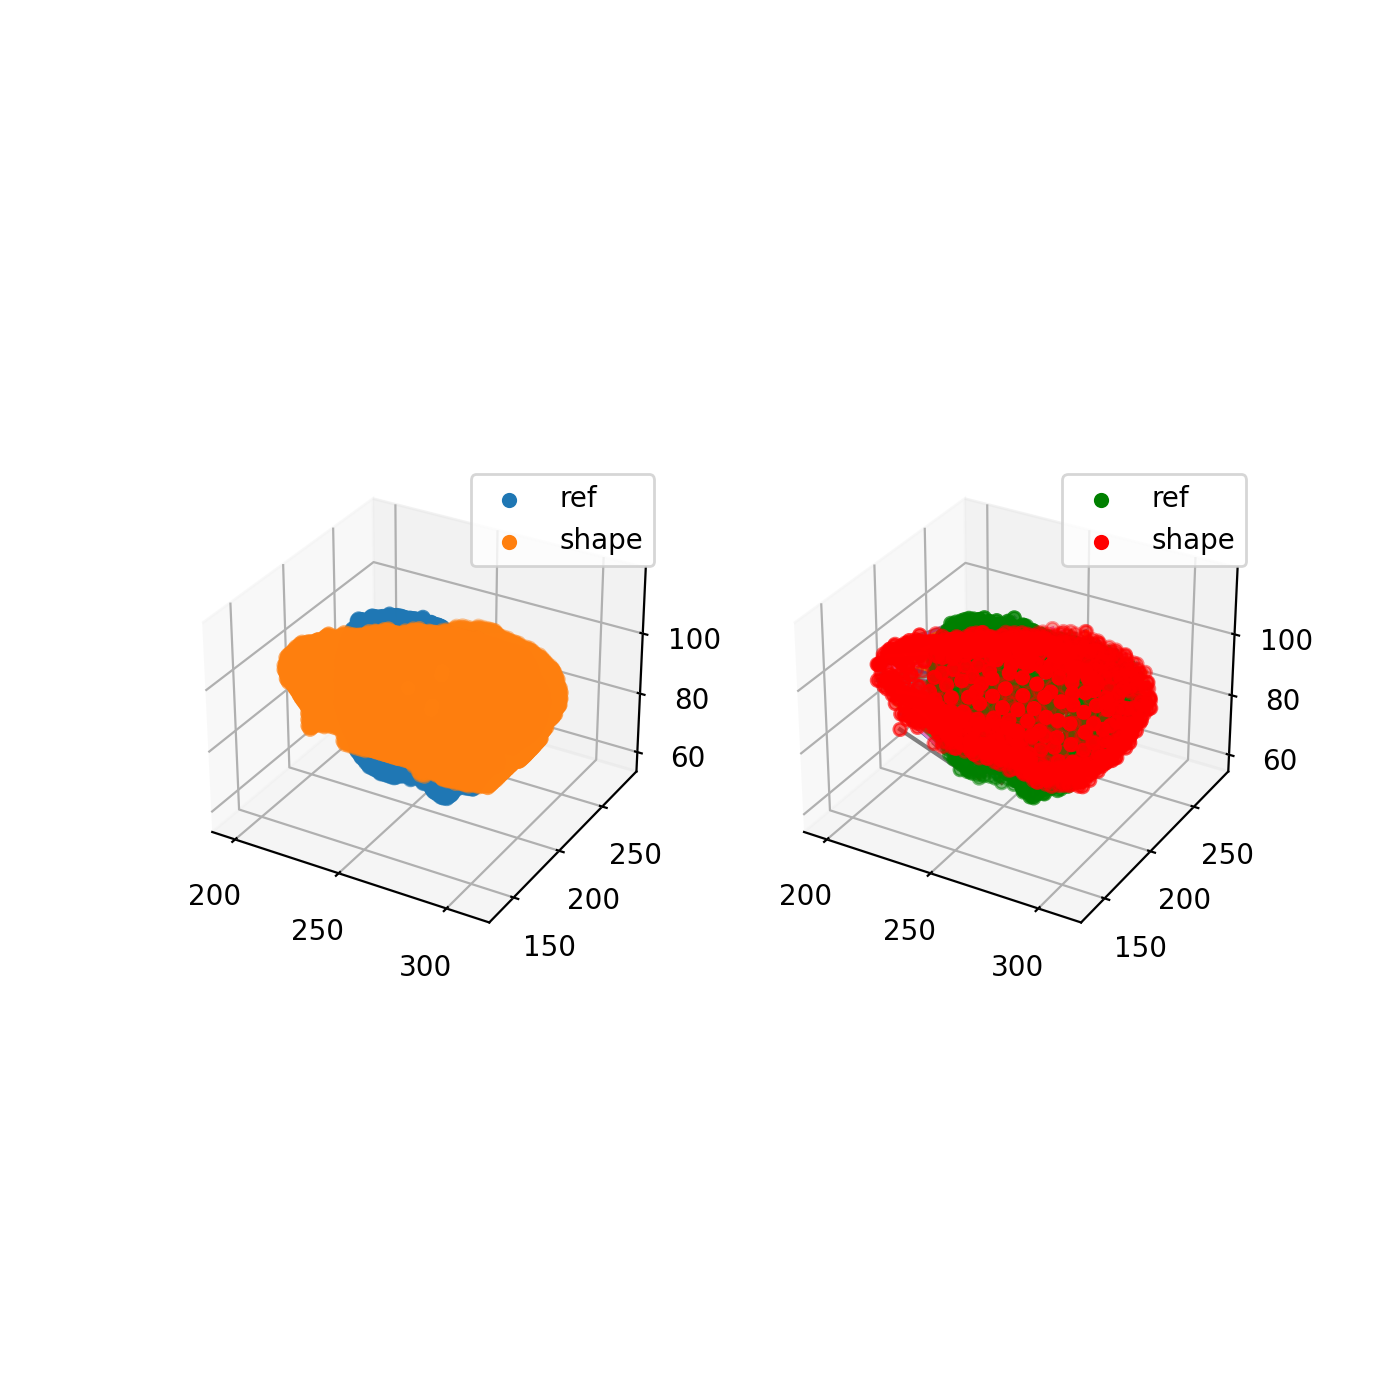

<Axes3DSubplot:>

In [10]:
cur_shape = random.choice(all_shapes)
print(cur_shape.label, cur_shape.origin_path)
print(cur_shape.Tref)
print(len(cur_shape.vertexes))

fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(121, projection='3d')
cur_shape.plot_compare_point_cloud(ax1, show_sampling=False)

ax1 = fig.add_subplot(122, projection='3d')
cur_shape.plot_compare_samples(ax1)

In [11]:
# An O3D look at the registration

reload_modules()
cur_shape.dijkstra_to_sample()

cur_mesh = cur_shape.o3d_mesh()
cur_pcd = cur_shape.o3d_pcd("b")
ref_mesh = cur_shape.o3d_ref_mesh_transformed()

draw([
    cur_mesh,
    cur_pcd,
    ref_mesh,
])

WebVisualizer(window_uid='window_1')

In [56]:
cur_mesh.


2

## Check normals

In [ ]:
# Check normals rotation conservation

pcd_ref = cur_shape.reference.o3d_pcd()
line_set1 = get_normal_lineset(
    pcd_ref, 2*cur_shape.reference.normals[cur_shape.reference.sample_idx])

ref_msh = cur_shape.reference.o3d_mesh()
Tref_msh = cur_shape.o3d_ref_mesh_transformed()

# Only rotation
Tref_msh2 = ou.numpy_to_o3d_mesh(
    vertices=cur_shape.reference.vertexes@cur_shape.Rotref.T,
    triangles=cur_shape.reference.faces
)
Tref_msh2.compute_vertex_normals()

# Only rotation
Rotpcd_ref = ou.numpy_to_o3d_pcd(
    cur_shape.reference.sample @ cur_shape.Rotref.T,
    normals=cur_shape.reference.normals[cur_shape.reference.sample_idx] @ cur_shape.Rotref.T
)
line_set2 = get_normal_lineset(Rotpcd_ref, 2*np.asarray(Rotpcd_ref.normals))


draw([
    line_set1,
    line_set2,
    ref_msh,
#     Tref_msh,
    Tref_msh2
])




In [ ]:
# Comparison of multiple normals

# Normals without applying rotation (should not match)
pcd_ref = ou.numpy_to_o3d_pcd(
    su.transform_cloud(cur_shape.Tref, cur_shape.reference.sample),
    normals=cur_shape.reference.normals[cur_shape.reference.sample_idx]
)
line_set1 = get_normal_lineset(pcd_ref, 2*np.asarray(pcd_ref.normals))

# Normals after rotation
pcd_ref2 = ou.numpy_to_o3d_pcd(
    su.transform_cloud(cur_shape.Tref, cur_shape.reference.sample),
    normals=cur_shape.reference.normals[
        cur_shape.reference.sample_idx] @ (cur_shape.Rotref.T)
)
line_set2 = get_normal_lineset(pcd_ref2, 2*np.asarray(pcd_ref2.normals))

ref_msh = ou.numpy_to_o3d_mesh(
    vertices=su.transform_cloud(cur_shape.Tref, cur_shape.reference.vertexes),
    triangles=cur_shape.reference.faces
)
ref_msh.compute_vertex_normals()

# Recomputation of normals
pcd_ref3 = ou.numpy_to_o3d_pcd(
    su.transform_cloud(cur_shape.Tref, cur_shape.reference.sample),
    normals=-np.asarray(ref_msh.vertex_normals)[cur_shape.reference.sample_idx]
)
line_set3 = get_normal_lineset(pcd_ref3, 2*np.asarray(pcd_ref3.normals))

# We should expect line_set2 and line_set3 to be good, and line_set1 to be bad
draw([
    pcd_ref,
    line_set1,
    line_set2,
    line_set3,
    ref_msh,
])

In [168]:
pcd_sample = ou.numpy_to_o3d_pcd(
    cur_shape.sample,
    normals=cur_shape.normals[cur_shape.sample_idx]
)
# pcd_sample.estimate_normals()


In [ ]:
%%time

# pcd_sample = cur_shape.o3d_pcd(normals=cur_shape.normals[cur_shape.sample_idx])

msh_sample = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd_sample, 
#     depth=15, 
#     width=0, 
#     scale=1.1, 
    linear_fit=False)[0]
msh_sample.compute_vertex_normals()
draw([pcd_sample, msh_sample, cur_mesh])

In [ ]:
%%time

reload_modules()

bpa_mesh = ou.ball_pivoting_mesh(pcd_sample)
draw([pcd_sample, bpa_mesh, cur_mesh])

## Compute statistics using registred shapes before

In [8]:
reload_modules()

shmodel = sh.SSM(
    shapes=[ref_shape] + all_shapes,
#         all_shapes[idx] for idx in sorted(set(range(len(all_shapes))).difference([2, 9]))], 
    reference=ref_shape
)
shmodel.compute_pca(remove_outliers=True)
shmodel.pca.explained_variance_ratio_.cumsum()

array([0.43170953, 0.69246966, 0.83224267, 0.8925692 , 0.9352187 ,
       0.96083659, 0.98399846, 1.        , 1.        ])

In [9]:
# Visualize PCA

idx = 0

pca0 = shmodel.get_component(idx)
normal = shmodel.pca_normals[idx]

pcd = ou.get_o3d_pcd_colored(points=pca0, normals=normal)
lineset = get_normal_lineset(pcd, 2 * normal)
lineset.paint_uniform_color([1, 0, 0])

msh_sample = random.choice(shmodel.shapes).create_mesh_from_sample_faces(pca0)
msh_sample_smooth = msh_sample.filter_smooth_simple()

draw([
    pcd,
    msh_sample,
    msh_sample_smooth,
    lineset
])

/hdd/aouadt/these/projets/3d_segm/ssm/shape.py:483: UserWarning: A shape did not compute its smoothed normals yet. Computing it.
  warnings.warn("A shape did not compute its smoothed normals yet. Computing it.")
/hdd/aouadt/these/projets/3d_segm/ssm/shape.py:402: UserWarning: Mesh graph not computed. Computing it.
  warnings.warn("Mesh graph not computed. Computing it.")
/hdd/aouadt/these/projets/3d_segm/ssm/shape.py:408: RuntimeWarning: invalid value encountered in true_divide
  self.normals_smooth = mean_normals / np.sqrt((mean_normals**2).sum(1))[:, np.newaxis]
/hdd/aouadt/these/projets/3d_segm/ssm/shape.py:386: UserWarning: Faces sample not yet computed. Is computed.
  warnings.warn("Faces sample not yet computed. Is computed.")


WebVisualizer(window_uid='window_0')

In [ ]:
# Visualize random generated mesh

(mesh, pcd), feats = shmodel.random_mesh_pca(scalar=2, sampling_mode="uniform")
mesh2 = mesh.filter_smooth_simple()

draw([
#     mesh,
    mesh2,
    pcd
])

In [ ]:
# Multiple shapes correspondance

idx1, idx2 = random.sample(range(len(shmodel.all_samples)), 2)
# idx1 = 0
print(idx1, idx2)
samp1, samp2 = shmodel.all_samples[[idx1, idx2]]
norms1, norms2 = shmodel.shapes[idx1].normals, shmodel.shapes[idx1].normals

pcd1 = ou.get_o3d_pcd_colored(samp1, 'g', normals=norms1)
pcd2 = ou.get_o3d_pcd_colored(samp2, 'r', normals=norms2)


line_set = get_lineset_matches(pcd1, pcd2)

draw([pcd1, pcd2, line_set])

In [77]:
ou.numpy_to_o3d_pcd(shmodel.get_shape_vertices_transformed(shape_idx))

PointCloud with 9654 points.

In [83]:
shape_idx = 1

ref_msh = shmodel.get_reference_mesh()
Tcur_msh = shmodel.get_shape_mesh_transformed(shape_idx)

cur_pcd = ou.get_o3d_pcd_colored(shmodel.all_samples[shape_idx])
lineset1 = get_normal_lineset(cur_pcd,
                              shmodel.all_sample_normals[shape_idx])
lineset1.paint_uniform_color([1, 0, 0])

lineset2 = get_normal_lineset(cur_pcd, shmodel.all_sample_normals_smooth[shape_idx])
lineset2.paint_uniform_color([0, 1, 0])

draw([
#     ref_msh,
    Tcur_msh,
    lineset1,
    lineset2,
])

WebVisualizer(window_uid='window_27')

In [68]:
# Check normals
i = 1
shp_idx = i
print(i)
cur_msh = ou..o3d_mesh()
ref_msh = shp0.o3d_ref_mesh_transformed()
cur_pcd = shp0.o3d_pcd()
ref_pcd = shp0.o3d_ref_pcd_transformed('r')
# msh = ou.numpy_to_o3d_mesh(
#     vertices=shp0.vertexes, triangles=shp0.faces
# )
# msh.compute_vertex_normals()
pcd = ou.numpy_to_o3d_pcd(shmodel.all_samples[shp_idx])
lineset = get_normal_lineset(pcd, shmodel.all_sample_normals_smooth[shp_idx])
lineset.paint_uniform_color([0, 1, 0])

lineset2 = get_normal_lineset(pcd, shmodel.all_sample_normals[shp_idx])
lineset2.paint_uniform_color([0.5, 0, 0.5])


draw([
#     pcd,
#     msh,
    cur_msh,
    cur_pcd,
#     ref_pcd,
    lineset,
    lineset2
])
i += 1

1


WebVisualizer(window_uid='window_23')

In [ ]:
# Check PCA normals

pcd_pca = shmodel.get_component(0)


In [67]:
# Link between SVD and PCA

all_sample_vector = shmodel.all_samples.reshape(len(shmodel), -1)
mean_sample = all_sample_vector.mean(0)
X = all_sample_vector - mean_sample
U, S, Vt = np.linalg.svd(X)
print("Principal components", 
      np.abs((U.T @ X)[:len(shmodel)] / S[:, np.newaxis] - Vt[:len(shmodel)]).sum(1) < 1e-5)
print("Principal components", 
      (np.abs((U.T @ X)[:len(shmodel)] / S[:, np.newaxis] - shmodel.pca.components_).sum(1) < 1e-5) |
     (np.abs((U.T @ X)[:len(shmodel)] / S[:, np.newaxis] + shmodel.pca.components_).sum(1) < 1e-5))
print("Singular values", 
      np.abs(S**2/(len(shmodel) - 1) - shmodel.pca.explained_variance_).sum() < 1e-5)

Principal components [ True  True  True  True  True  True  True  True  True  True False]
Principal components [ True  True  True  True  True  True  True  True  True  True False]
Singular values True


In [160]:
# Compare the sample submesh for each shape  
nb_same_faces = np.zeros((len(shmodel), len(shmodel)))

for idx in tqdm(range(len(shmodel))):
    shmodel.shapes[idx].compute_sample_faces()

for idx1 in tqdm(range(len(shmodel))):
    for idx2 in range(idx1 + 1, len(shmodel)):
        in_the_other = []
        for face in shmodel.shapes[idx1].faces_sample:
            if (np.abs(face - shmodel.shapes[idx2].faces_sample).sum(1) == 0).sum() > 0:
                in_the_other.append(face)
        nb_same_faces[idx1, idx2] = len(in_the_other)

print(nb_same_faces)

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

[[  0. 276. 219. 267. 315.  99. 190. 334. 230.]
 [  0.   0. 101. 129. 168.  65.  78. 119. 100.]
 [  0.   0.   0.  92. 126.  38.  77. 106.  93.]
 [  0.   0.   0.   0. 164.  43. 102. 132. 103.]
 [  0.   0.   0.   0.   0.  67. 108. 191. 122.]
 [  0.   0.   0.   0.   0.   0.  53.  55.  48.]
 [  0.   0.   0.   0.   0.   0.   0. 126.  71.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 113.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]]


# Shape Creation on iliac

## Test Load Iliac

In [5]:
%%time
reload_modules()
mesh_left = sh.Shape.load_obj_from_path('data/CT-SCANS/dicoms/patient_8/Segmentation-iliac-left.obj')
mesh_left.perform_sampling(3000, verbose=True)
mesh_left.compute_sample_faces()
mesh_left.set_sample_as_vertexes()


100%|██████████| 3000/3000 [01:02<00:00, 48.11it/s]


CPU times: user 1min 26s, sys: 36.4 s, total: 2min 2s
Wall time: 1min 13s


In [ ]:
msh_sample = mesh_left.o3d_mesh()
draw(msh_sample)

## Check connected components

In [58]:
# Check connected components
reload_modules()

n_ccs = []
for patient in tqdm(range(1, 9)):
    for side in ['right', 'left']:
        shape_6 = sh.Shape.load_obj_from_path(
            f"data/CT-SCANS/dicoms/patient_{patient}/Segmentation-iliac-{side}.obj")
        gnx = shape_6.get_nx_graph()
        n_ccs.append(len(list(nx.connected_components(gnx))))
print(n_ccs)

100%|██████████| 8/8 [00:46<00:00,  5.85s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


## Computing shapes

In [6]:
labels_path = "data/CT-SCANS/meshes/iliac/labels_descriptions.csv"
df_labels = pd.read_csv(labels_path)

In [7]:
%%time
# Using shape class
reload_modules()


n_samples = 1000
candidates = df_labels[
    (df_labels['step_size'].isna()) & (df_labels['n_vertexes'] == n_samples)]

all_mesh_paths = candidates['full_path'].values

# ref_shape = sh.Shape.load_obj_from_path(
#     all_mesh_paths[0], Tref=np.eye(4), label=all_mesh_paths[0])

# print("Downsampling...")
# ref_shape.uniform_downsample(n_samples, True)
# print("Done.")
ref_path = all_mesh_paths[0]
print(ref_path)
ref_shape = sh.Shape.load_numpy_from_path(ref_path, Tref=np.eye(4))
ref_shape.perform_sampling(n_samples);
print('Done')

/hdd/aouadt/these/projets/3d_segm/data/CT-SCANS/meshes/iliac/patient_1/left/downsample_1000
Done
CPU times: user 381 ms, sys: 315 ms, total: 696 ms
Wall time: 293 ms


In [106]:
# Using classic ICP (nearest neighbor) with Perfect Matching Sampling

n_shapes = 15
all_shapes = []
all_errs = []
all_n_iters = []
not_converged = []

# iterator = su.sort_by_regex(list(set(all_meshes).difference([ref_mesh])))[10:10+n_shapes]
iterator = all_mesh_paths[1: 1+n_shapes]
for idx in tqdm(range(len(iterator))):
    mesh_path = iterator[idx]
#     cur_shape = sh.Shape.load_obj_from_path(mesh_path, reference=ref_shape, label=mesh_path)
#     cur_shape.uniform_downsample(n_samples)
    cur_shape = sh.Shape.load_numpy_from_path(mesh_path, reference=ref_shape, label=mesh_path)
    
    # mirror right to left
    if "right" in mesh_path:
        cur_shape.vertexes[:, 0] *= -1
    cur_shape.perform_sampling(n_samples)
    _, _, errs, n_iters = cur_shape.register_icp_to_reference(max_iterations=100, allow_reflection=True)
    
    if n_iters == 99:
        not_converged.append([idx, cur_shape])
    elif np.linalg.norm(cur_shape.Tref[:3, :3]) < 1e-5:
        not_converged.append([idx, cur_shape])
    
    else:
#         cur_shape.perform_sampling(len(cur_shape.reference.sample_idx))
        cur_shape.match_samples(matching_method="nearest")

        all_shapes.append(cur_shape)
        all_errs.append(errs)
        all_n_iters.append(n_iters)
        
print("Not converged:", len(not_converged))

100%|██████████| 15/15 [00:03<00:00,  4.74it/s]

Not converged: 0


In [10]:
not_converged

[[0, <ssm.shape.Shape at 0x7f49e002f130>],
 [4, <ssm.shape.Shape at 0x7f4998853550>],
 [6, <ssm.shape.Shape at 0x7f49b3f0adf0>],
 [14, <ssm.shape.Shape at 0x7f49c3f73e50>]]

## Check Registration results

In [21]:
np.linalg.det(cur_shape.Tref[:3, :3])

0.00468420837853875

In [122]:
idx = 15
cur_shape = all_shapes[idx]
print(cur_shape.label)
print(ref_shape.label)

cur_msh = cur_shape.o3d_mesh()
cur_pcd = cur_shape.o3d_pcd()
ref_msh = cur_shape.o3d_ref_mesh_transformed()
ref_pcd = cur_shape.o3d_ref_pcd_transformed(point_color='b')
ref_pcd_pre = ref_shape.o3d_pcd(point_color='r')
draw([
    cur_pcd,
    ref_pcd,
    ref_pcd_pre
#     cur_msh,
#     ref_msh
])

IndexError: list index out of range

In [43]:
all_shapes = [shp for shp in all_shapes if "left" in shp.label]

In [49]:
# Multiple shapes correspondance

idx1, idx2 = random.sample(range(len(shmodel.all_samples)), 2)
# idx1 = 0
print(idx1, idx2)
samp1, samp2 = shmodel.all_samples[[idx1, idx2]]
# norms1, norms2 = shmodel.shapes[idx1].normals, shmodel.shapes[idx1].normals

pcd1 = ou.get_o3d_pcd_colored(samp1, 'g', )
pcd2 = ou.get_o3d_pcd_colored(samp2, 'r', )


line_set = get_lineset_matches(pcd1, pcd2)

draw([pcd1, pcd2, line_set])

5 0


WebVisualizer(window_uid='window_24')

## Compute statistics

In [130]:
reload_modules()

shmodel = sh.SSM(
    shapes=[ref_shape] + all_shapes,
#         all_shapes[idx] for idx in sorted(set(range(len(all_shapes))).difference([2, 9]))], 
    reference=ref_shape
)
shmodel.compute_pca(remove_outliers=True)
shmodel.pca.explained_variance_ratio_.cumsum()

array([0.1355687 , 0.2416462 , 0.34315984, 0.4357549 , 0.50940481,
       0.58249895, 0.64743305, 0.71008664, 0.771371  , 0.82893819,
       0.88393192, 0.93689067, 0.98578674, 1.        , 1.        ])

In [131]:
shmodel.inliers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True])

In [135]:
shmodel.shapes[-3].label

'/hdd/aouadt/these/projets/3d_segm/data/CT-SCANS/meshes/iliac/patient_7/right/downsample_1000'

In [133]:
# Visualize PCA

idx = 0

pca0 = shmodel.get_component(idx)
pcd = ou.get_o3d_pcd_colored(pca0, 'r')
# normal = shmodel.pca_normals[idx]

# pcd = ou.get_o3d_pcd_colored(points=pca0, normals=normal)
# lineset = get_normal_lineset(pcd, 2 * normal)
# lineset.paint_uniform_color([1, 0, 0])

# msh_sample = random.choice(shmodel.shapes).create_mesh_from_sample_faces(pca0)
msh_sample = (shmodel.reference).create_mesh_from_sample_faces(pca0)
msh_sample_smooth = msh_sample.filter_smooth_simple()

draw([
#     pcd,
    pcd,
    msh_sample,
    msh_sample_smooth,
#     lineset
])

WebVisualizer(window_uid='window_61')

In [100]:
su.random_color_generator(1)

array([[0.58653706, 0.58653706, 0.58653706, 1.        ]])

In [139]:
# Visualize random generated mesh

n_gens = 2

mshs, smooth_mshs, pcds = [], [], []
for _ in range(n_gens):
    (mesh, pcd), feats = shmodel.random_mesh_pca(scalar=2, sampling_mode="uniform", shape_reference_faces=shmodel.reference)
    mesh2 = mesh.filter_smooth_simple()

    col = su.random_color_generator(1, RGB=True)[0, :-1]
    pcd.paint_uniform_color(col)
    mesh.paint_uniform_color(col)
    mesh2.paint_uniform_color(col)
    
    
    mshs.append(mesh)
    smooth_mshs.append(mesh2)
    pcds.append(pcd)

    
draw(
    pcds + 
    mshs + 
#     smooth_mshs +
    []
)    

# draw([
#     mesh,
#     mesh2,
#     pcd
# ])

WebVisualizer(window_uid='window_65')

# II) Inference